<img src="img/saturn_logo.png" width="300" />

# Monitoring Model Learning Performance

Let's take a look at the results we get from running this exact workflow on a few different cluster sizes. You've been given the statistics results from real job runs in the repo. 

Run the next chunk, which is a bash command. This will decompress the statistics into your directory.

In [ ]:
%%sh
cd ~/project/workshop-dask-pytorch/
gzip -d < ~/project/workshop-dask-pytorch/stats_cache2.tar.gz | tar xvf - > /dev/null

In [35]:
from os.path import dirname, join
import pandas as pd
import os
import typing
import json
from plotnine import *
import plotnine
import dateutil.parser
import pandas as pd

def parse_results(root):
    workers_dir = join(root, 'worker')
    workers = [int(x) for x in os.listdir(workers_dir)]
    data = []
    for w in workers:
        worker_dir = join(root, 'worker', str(w))
        worker_files = sorted(os.listdir(worker_dir))
        for idx, file in enumerate(worker_files):
            date_str = file.split('data-')[-1].split('.')[0]
            fpath = join(worker_dir, file)
            d = dict(
                count=idx,
            )
            with open(fpath) as f:
                d.update(json.load(f))
            data.append(d)
    return data

In [36]:
def process_run(dictinput):
    path, rtype, compute, size, lr, workers = dictinput
    df = pd.DataFrame(parse_results(path))
    cleaned = df[['count', 'loss', 'correct', 'sample']].groupby(['count', 'sample']).agg({'loss': ['mean', 'min', 'max'],'correct': ['mean', 'min', 'max']}).reset_index()
    cleaned['type'], cleaned['compute'], cleaned['size'], cleaned['lr'], cleaned['workers'] = [rtype,compute, size, lr, workers]
    return cleaned

def process_run_epochs(dictinput):
    path, rtype, compute, size, lr, workers = dictinput
    df = pd.DataFrame(parse_results(path))
    cleaned = df[['epoch', 'loss', 'correct', 'sample']].groupby(['epoch', 'sample']).agg({'loss': ['mean', 'min', 'max'],'correct': ['mean', 'min', 'max']}).reset_index()
    cleaned['type'], cleaned['compute'], cleaned['size'], cleaned['lr'], cleaned['workers'] = [rtype,compute, size, lr, workers]
    return cleaned

# looplist = [["./stats/parallel/pt8_4wk","parallel-4worker","parallel",100,'adaptive_01', 4],
#             ["./stats/parallel/pt8_10wk","parallel-10worker","parallel",100,'adaptive_01', 10],
#             ["./stats/parallel/pt8_7wk","parallel-7worker","parallel",100,'adaptive_01', 7],
#             ["./stats/singlenode/pt8", "single","single",100, 'adaptive_01', 1],
#            ]

looplist = [["./stats_cache/workers4","parallel-4worker","parallel",100,'adaptive_01', 4],
            ["./stats_cache/workers7","parallel-7worker","parallel",100,'adaptive_01', 7],
           ]


results = list(map(process_run, looplist))
e_results = list(map(process_run_epochs, looplist))

test4 = pd.concat(results, axis=0)
etest4 = pd.concat(e_results, axis=0)

etest4.columns = [''.join(col).strip() for col in etest4.columns.values]
test4.columns = [''.join(col).strip() for col in test4.columns.values]

plotnine.options.figure_size = (11,4)


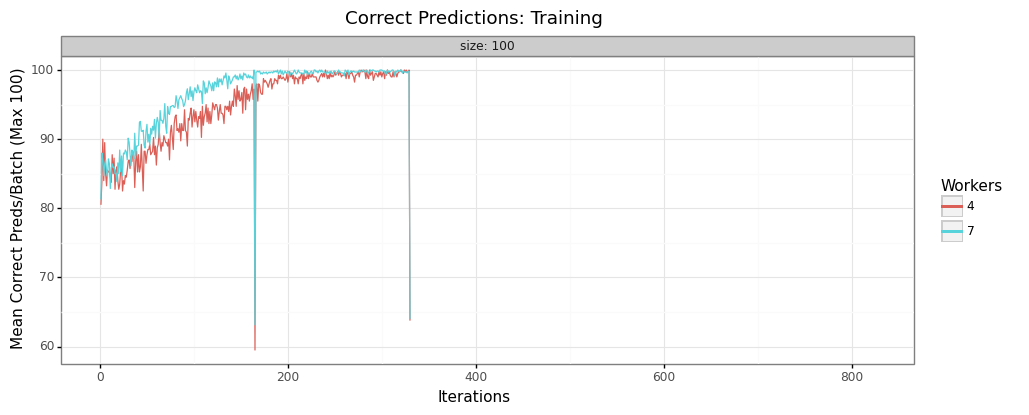

<ggplot: (8785129029081)>

In [37]:
test6 = test4.query('sample == "train"')
(ggplot(test6, aes(x='count', y='correctmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Correct Predictions: Training', x="Iterations", y="Mean Correct Preds/Batch (Max 100)", color = "Workers"))

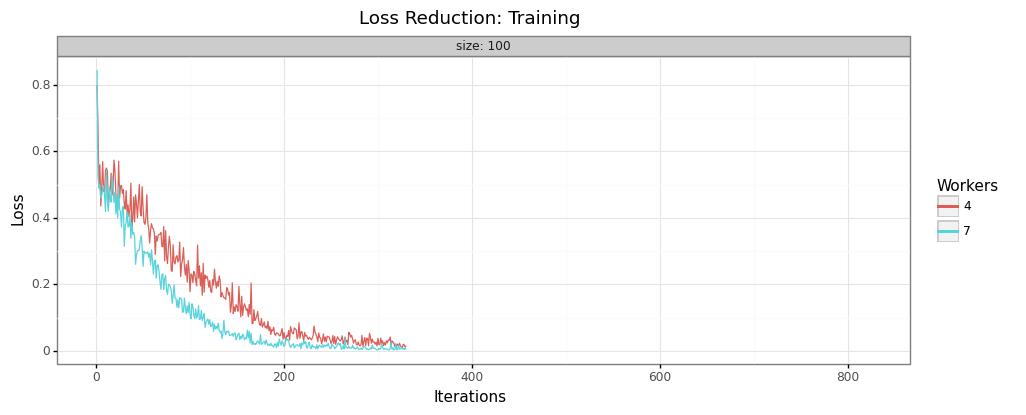

<ggplot: (8785127939853)>

In [38]:
(ggplot(test6, aes(x='count', y='lossmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Loss Reduction: Training', x="Iterations", y="Loss", color = "Workers"))

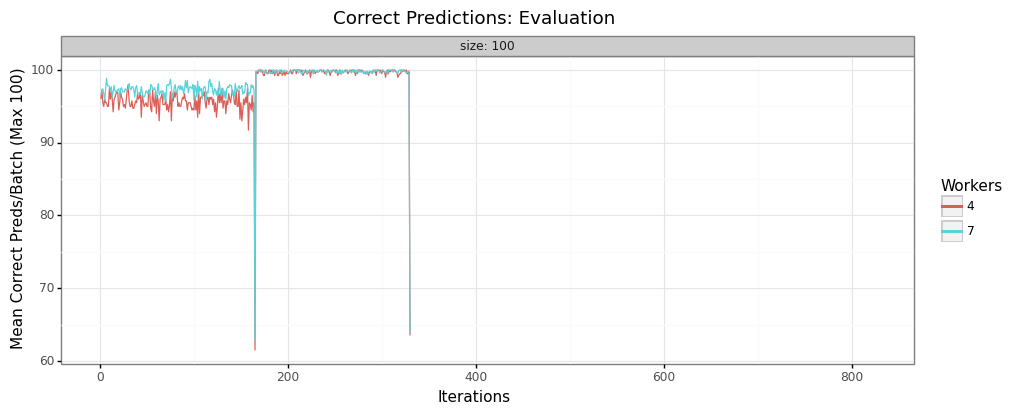

<ggplot: (8785127942093)>

In [39]:
test6 = test4.query('sample == "eval"')
(ggplot(test6, aes(x='count', y='correctmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Correct Predictions: Evaluation', x="Iterations", y="Mean Correct Preds/Batch (Max 100)", color = "Workers"))

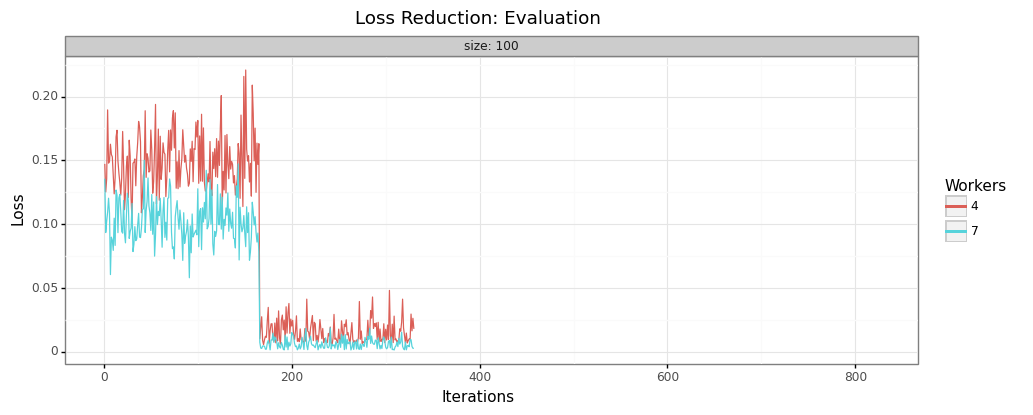

<ggplot: (8785128296181)>

In [40]:
(ggplot(test6, aes(x='count', y='lossmean', color = "factor(workers)", group = 'type'))
        + facet_wrap(facets = ("size"), ncol=3, labeller='label_both')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Loss Reduction: Evaluation', x="Iterations", y="Loss", color = "Workers"))

/srv/conda/envs/saturn/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/srv/conda/envs/saturn/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


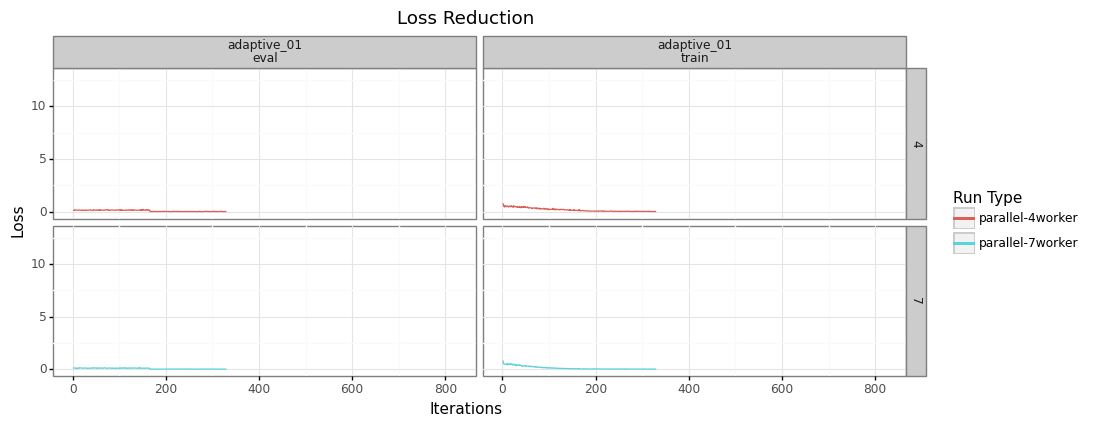

<ggplot: (8785127912081)>

In [41]:
(ggplot(test4, aes(x='count', y='lossmean', color = "factor(type)", group = 'type'))
        + facet_grid('workers~lr+sample')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + ylim(0, 13)
        + labs(title = 'Loss Reduction', x="Iterations", y="Loss", color = "Run Type"))

/srv/conda/envs/saturn/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:136: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
/srv/conda/envs/saturn/lib/python3.7/site-packages/plotnine/facets/facet_grid.py:137: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead


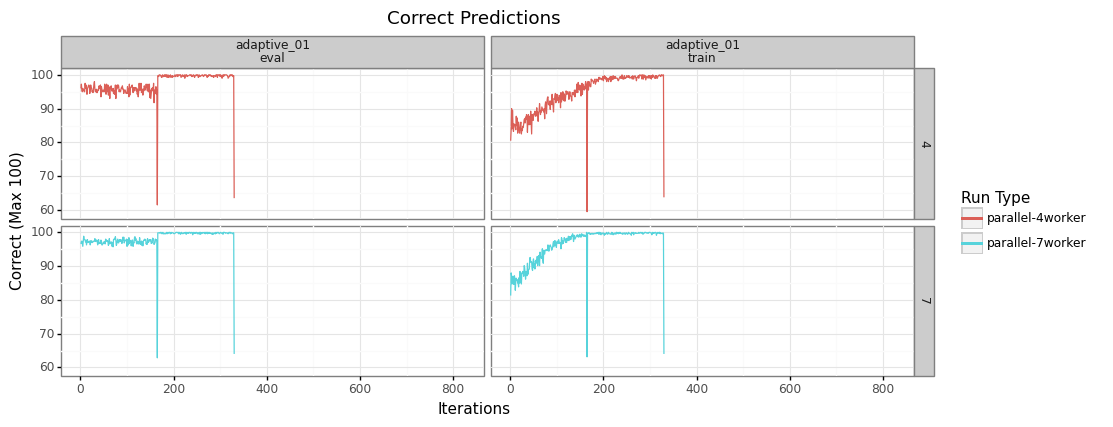

<ggplot: (8785128736545)>

In [42]:
(ggplot(test4, aes(x='count', y='correctmean', color = "factor(type)", group = 'type'))
        + facet_grid('workers~lr+sample')
        + theme_bw()
        + geom_line()
        + xlim(0, 825)
        + labs(title = 'Correct Predictions', x="Iterations", y="Correct (Max 100)", color = "Run Type"))

In [43]:
test4

,count,sample,lossmean,lossmin,lossmax,correctmean,correctmin,correctmax,type,compute,size,lr,workers
0,1,eval,0.147211,0.091292,0.171978,96.000000,94,100,parallel-4worker,parallel,100,adaptive_01,4
1,1,train,0.798833,0.758287,0.847975,80.500000,79,85,parallel-4worker,parallel,100,adaptive_01,4
2,2,eval,0.125189,0.101169,0.160290,97.250000,96,98,parallel-4worker,parallel,100,adaptive_01,4
3,2,train,0.672781,0.585994,0.710757,83.750000,80,87,parallel-4worker,parallel,100,adaptive_01,4
4,3,eval,0.135722,0.117879,0.173622,95.500000,94,97,parallel-4worker,parallel,100,adaptive_01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,328,train,0.004117,0.001857,0.010961,99.857143,99,100,parallel-7worker,parallel,100,adaptive_01,7
656,329,eval,0.002667,0.000915,0.009170,99.857143,99,100,parallel-7worker,parallel,100,adaptive_01,7
657,329,train,0.009572,0.001992,0.037506,99.714286,99,100,parallel-7worker,parallel,100,adaptive_01,7
658,330,eval,0.002690,0.000898,0.011566,64.000000,64,64,parallel-7worker,parallel,100,adaptive_01,7
